### 1. Environment Setup

In [ ]:
# Optional: Mount Google Drive if needed
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Load YOLOv8 Model

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

# Load trained YOLOv8 model
model = YOLO('/content/drive/MyDrive/GUVI/ANPR/model/best.pt')  # Update path if needed

# Display model info
model.info()

Model summary: 169 layers, 25,856,899 parameters, 0 gradients, 79.1 GFLOPs


(169, 25856899, 0, 79.0656)

### 3. Upload or Use Test Images/Videos

Saving TEST.jpeg to TEST.jpeg
Uploaded: TEST.jpeg


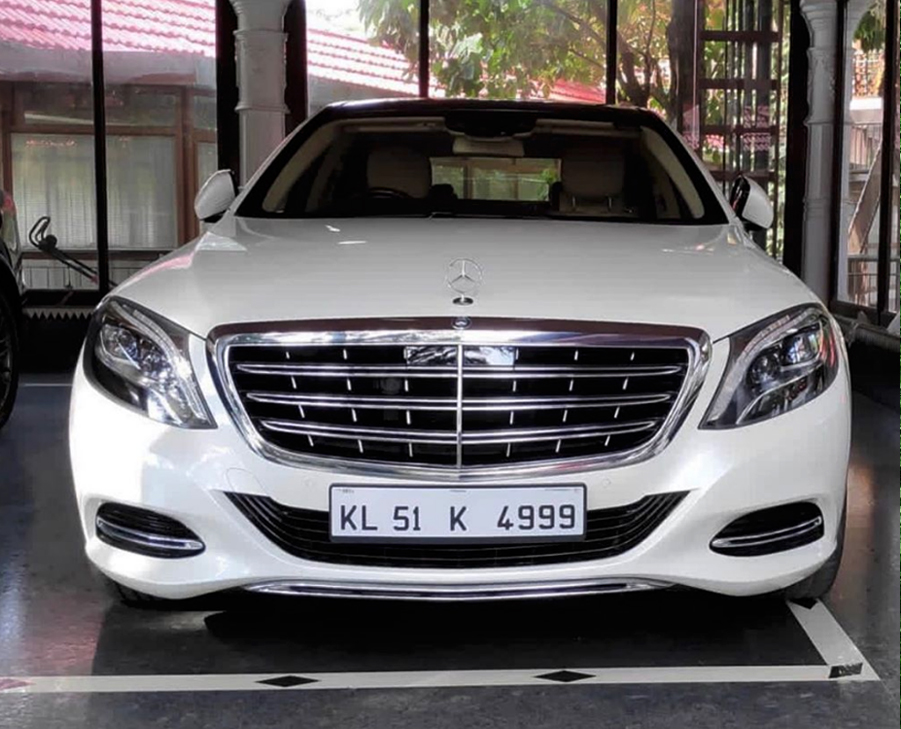

In [ ]:
from google.colab import files
import cv2
from IPython.display import Image, display
import os

# Upload image or video files
uploaded = files.upload()

# Preview uploaded files
for filename in uploaded.keys():
    print(f"Uploaded: {filename}")
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        display(Image(filename))

### 4. Image Preprocessing (Optional for OCR)

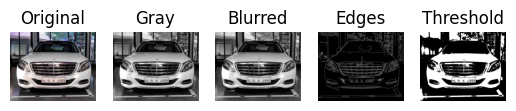

In [ ]:
import matplotlib.pyplot as plt

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 100, 200)
    _, thresh = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)

    # Show steps
    titles = ['Original', 'Gray', 'Blurred', 'Edges', 'Threshold']
    images = [img, gray, blur, edges, thresh]
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Example usage
preprocess_image(list(uploaded.keys())[0])

### 5. License Plate Detection (YOLO Inference)


image 1/1 /content/TEST.jpeg: 544x640 1 license_plate, 93.0ms
Speed: 12.6ms preprocess, 93.0ms inference, 317.2ms postprocess per image at shape (1, 3, 544, 640)


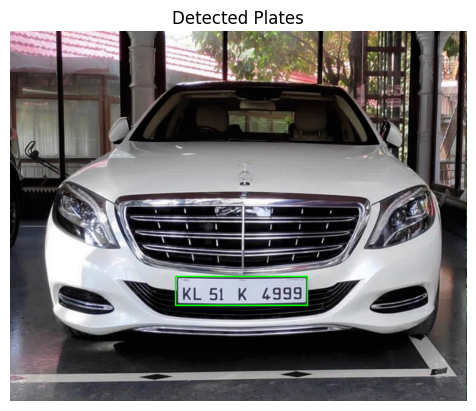

In [ ]:
import cv2
import matplotlib.pyplot as plt

def detect_plates(image_path):
    results = model(image_path)
    result = results[0]
    img = cv2.imread(image_path)

    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Plates")
    plt.axis('off')
    plt.show()

# Example usage
detect_plates(list(uploaded.keys())[0])

### 6. Region of Interest (ROI) Extraction


image 1/1 /content/TEST.jpeg: 544x640 1 license_plate, 35.8ms
Speed: 3.5ms preprocess, 35.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


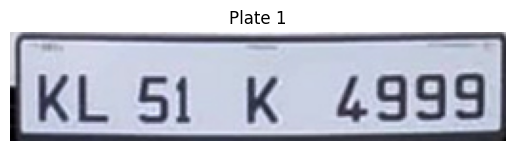

In [ ]:
def extract_rois(image_path):
    results = model(image_path)
    result = results[0]
    img = cv2.imread(image_path)
    rois = []

    for i, box in enumerate(result.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        roi = img[y1:y2, x1:x2]
        rois.append(roi)
        plt.subplot(1, len(result.boxes), i+1)
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title(f"Plate {i+1}")
        plt.axis('off')
    plt.show()
    return rois

# Example usage
rois = extract_rois(list(uploaded.keys())[0])

### 7. Character Recognition using Tesseract

In [ ]:
!pip install pytesseract

In [ ]:
import pytesseract

def ocr_rois(rois):
    plate_numbers = []
    for i, roi in enumerate(rois):
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        text = pytesseract.image_to_string(gray, config='--psm 8')
        cleaned = ''.join(filter(str.isalnum, text))
        plate_numbers.append(cleaned)
        print(f"Plate {i+1}: {cleaned}")
    return plate_numbers

# Example usage
recognized_plates = ocr_rois(rois)


Plate 1: KL51K4999


### 8. Real-Time Detection using Webcam/Video

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import pytesseract
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame_count > 10:  # Limit frames for Colab preview
            break
        results = model(frame)
        result = results[0]
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            roi = frame[y1:y2, x1:x2]
            text = pytesseract.image_to_string(cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY), config='--psm 8')
            cleaned = ''.join(filter(str.isalnum, text))
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(frame, cleaned, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)
        # Show frame in Colab
        cv2_imshow(frame)
        frame_count += 1
    cap.release()

process_video('/content/drive/MyDrive/GUVI/ANPR/test/TEST.mp4')

### 9. Logging Results

In [ ]:
import pandas as pd
from datetime import datetime

def log_results(plate_numbers):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    df = pd.DataFrame({'Plate Number': plate_numbers, 'Timestamp': [timestamp]*len(plate_numbers)})
    df.to_csv('recognized_plates.csv', index=False)
    print(df)

# Example usage
log_results(recognized_plates)

  Plate Number            Timestamp
0    KL51K4999  2025-09-12 07:27:52


In [ ]:
# Logging function
def log_to_csv(plate_numbers):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    df = pd.DataFrame({'Plate Number': plate_numbers, 'Timestamp': [timestamp]*len(plate_numbers)})
    if os.path.exists('recognized_plates.csv'):
        df.to_csv('recognized_plates.csv', mode='a', header=False, index=False)
    else:
        df.to_csv('recognized_plates.csv', index=False)
    print("Logged results:")
    print(df)

## 10. Upload Image for Detection
Upload an image file to detect license plates and perform OCR.

Saving TEST.jpeg to TEST (1).jpeg

0: 544x640 1 license_plate, 35.7ms
Speed: 3.3ms preprocess, 35.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


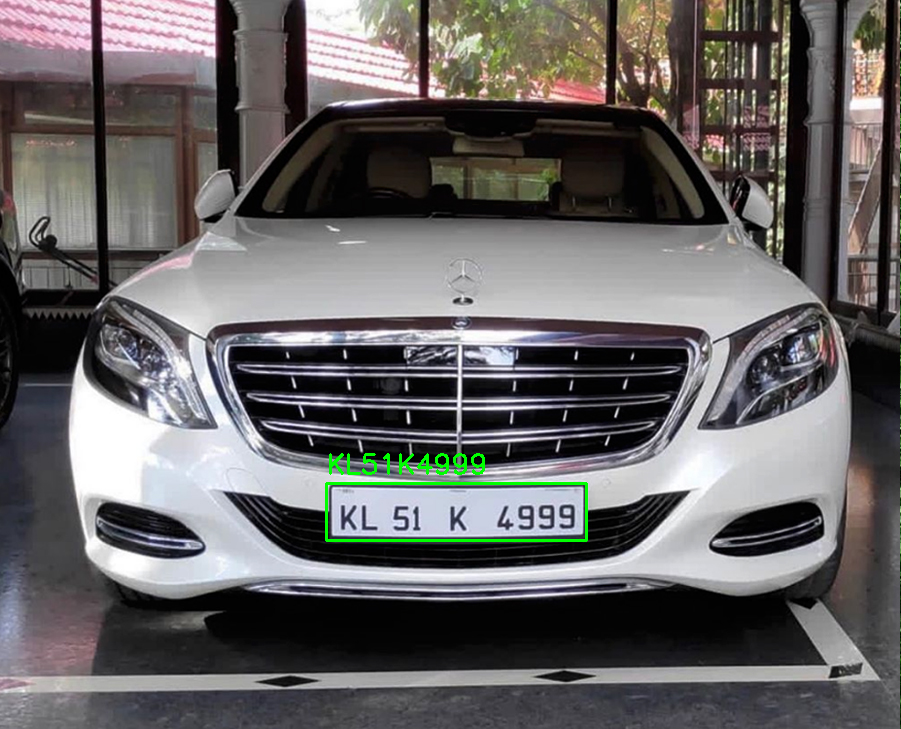

Logged results:
  Plate Number            Timestamp
0    KL51K4999  2025-09-12 07:28:06


In [ ]:
# Upload and process image
image_upload = files.upload()
image_path = list(image_upload.keys())[0]
img = cv2.imread(image_path)
results = model(img)
result = results[0]
plate_numbers = []

for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    roi = img[y1:y2, x1:x2]
    text = pytesseract.image_to_string(cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY), config='--psm 8')
    cleaned = ''.join(filter(str.isalnum, text))
    plate_numbers.append(cleaned)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(img, cleaned, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

cv2_imshow(img)
log_to_csv(plate_numbers)


## 11. Upload Video for Detection
Upload a video file to detect license plates and perform OCR on frames.


In [ ]:

# Upload and process video
#video_upload = files.upload()
#video_path = list(video_upload.keys())[0]
cap = cv2.VideoCapture("/content/drive/MyDrive/GUVI/ANPR/test/TEST.mp4")
frame_count = 0
video_plate_numbers = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame_count > 10:
        break
    results = model(frame)
    result = results[0]
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        roi = frame[y1:y2, x1:x2]
        text = pytesseract.image_to_string(cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY), config='--psm 8')
        cleaned = ''.join(filter(str.isalnum, text))
        video_plate_numbers.append(cleaned)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(frame, cleaned, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
    cv2_imshow(frame)
    frame_count += 1

cap.release()
log_to_csv(video_plate_numbers)
